### [실습] 스타일 전이 학습

- 스타일 이미지 1장 + 콘텐츠 이미지 3장

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

# 함수 정의 : 이미지 로드 + transform
def load_image(img_url, max_size=400):
  response = requests.get(img_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  size = max(image.size) if max(image.size) < max_size else max_size
  transform = transforms.Compose([
      transforms.Resize((size,size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
  ])
  return transform(image).unsqueeze(0)

In [ ]:
# 함수 정의
def img_convert(tensor):
  image = tensor.to('cpu').clone().detach().squeeze()   # squeeze: 배치 차원 없어지게함
  image = image.numpy().transpose(1,2,0)  # 가로, 세로, 차원 <-이 되게 순서 바꿔줌
  image = image * [0.229,0.224,0.225]
  image = image + [0.485,0.456,0.406]
  return image.clip(0,1)

In [11]:
content_1_url = "https://raw.githubusercontent.com/Haer111/transfer-style-practice/main/%EC%BD%98%ED%85%90%EC%B8%A0%20%EC%9D%B4%EB%AF%B8%EC%A7%80%201.jpg"
content_2_url = "https://raw.githubusercontent.com/Haer111/transfer-style-practice/main/%EC%BD%98%ED%85%90%EC%B8%A0%20%EC%9D%B4%EB%AF%B8%EC%A7%80%202.webp"
content_3_url = "https://raw.githubusercontent.com/Haer111/transfer-style-practice/main/콘텐츠%20이미지%203.png"
style_url = "https://raw.githubusercontent.com/Haer111/transfer-style-practice/main/스타일%20이미지%201.jpg"

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 로드
content_1 = load_image(content_1_url).to(device)
content_2 = load_image(content_2_url).to(device)
content_3 = load_image(content_3_url).to(device)
style = load_image(style_url).to(device)

In [13]:
import torchvision.models as models

# 모델 로드 (특징 추출 레이어)
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# 함수 정의: 특정 레이어를 통과한 feature를 반환
def get_features(image, model):
  layers = {
      "0":"conv1_1",
      "5":"conv2_1",
      "10":"conv3_1",
      "19":"conv4_1",
      "21":"conv4_2",
      "28":"conv5_1"
  }
  features = {}

  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [15]:
# 함수 정의 : 스타일 표현에 대한 행렬 반환
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  return torch.mm(tensor, tensor.t()) # matmul 내적계산

In [16]:
contents = [content_1, content_2, content_3]
style_features = get_features(style, vgg)
style_grams = {feature: gram_matrix(style_features[feature]) for feature in style_features}

targets = []
optimizers = []

for c in contents:
    content_features = get_features(c, vgg)
    target = c.clone().requires_grad_(True)
    optim = torch.optim.Adam([target], lr=0.003)
    targets.append(target)
    optimizers.append(optim)

style_weight = 1e6
content_weight = 1


In [19]:
num_steps = 300

for step in range(num_steps):
    for idx, target in enumerate(targets):
        target_features = get_features(target, vgg)

        # 콘텐츠 손실 계산
        content_loss = torch.mean((target_features["conv4_2"] - get_features(contents[idx], vgg)["conv4_2"]) ** 2)

        # 스타일 손실 계산
        style_loss = 0
        for layer in style_grams:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer]
            layer_loss = torch.mean((target_gram - style_gram) ** 2)
            style_loss += layer_loss / (target_features[layer].shape[1] ** 2)

        # 총 손실 계산
        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizers[idx].zero_grad()
        total_loss.backward()
        optimizers[idx].step()


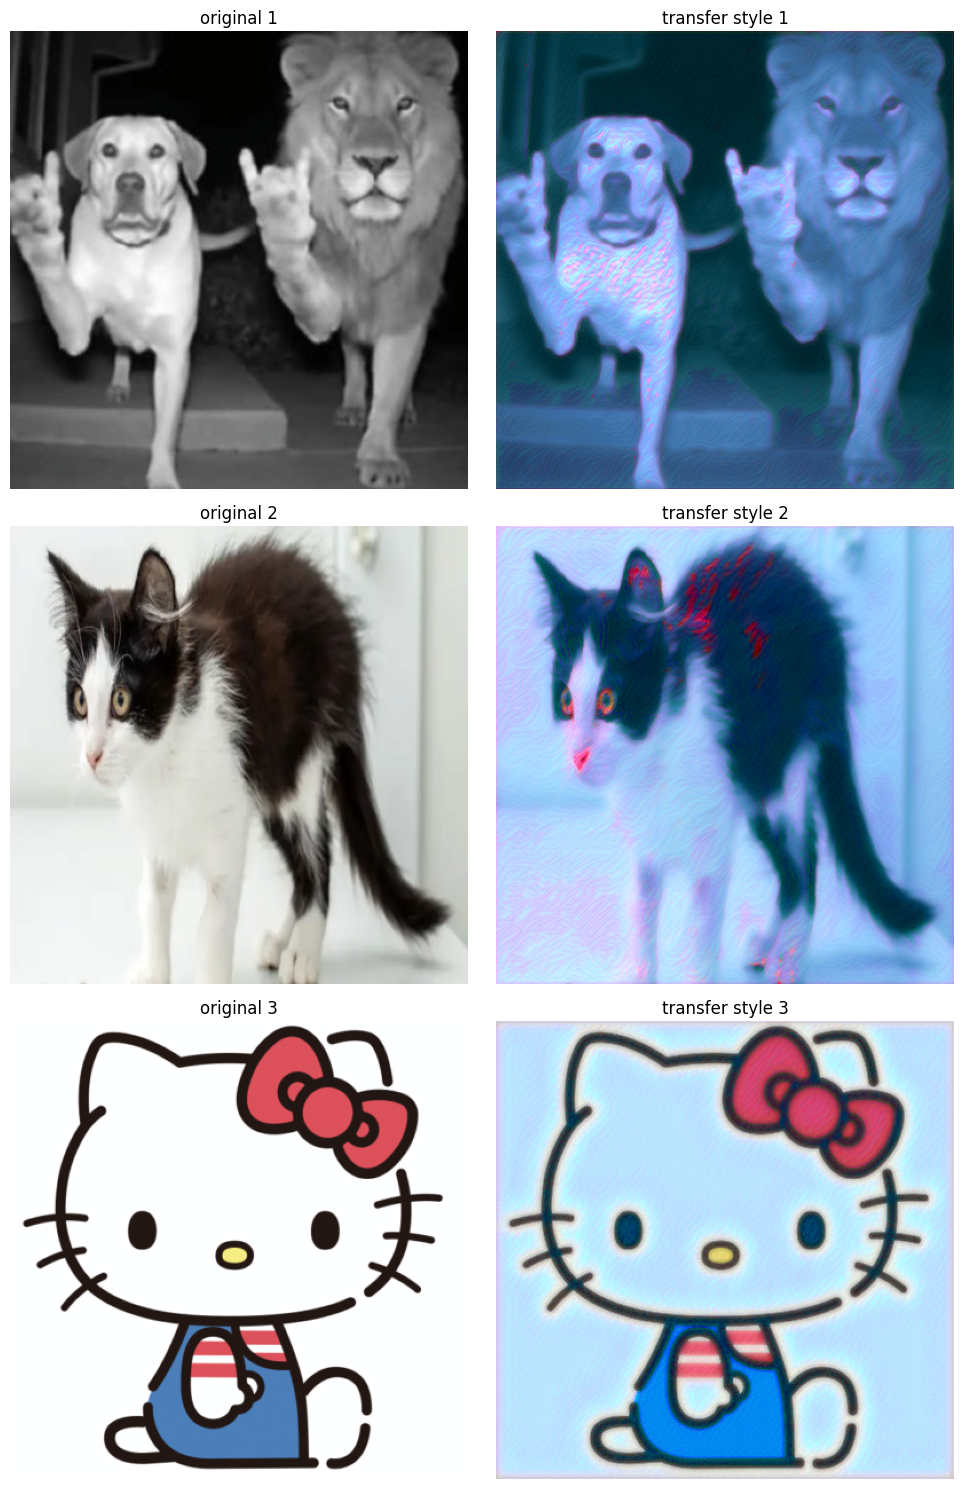

In [20]:
import matplotlib.pyplot as plt

n = len(contents)

plt.figure(figsize=(10, 5 * n))

for i in range(n):
    # 원본 이미지
    plt.subplot(n, 2, 2*i + 1)
    plt.imshow(img_convert(contents[i]))
    plt.title(f"original {i+1}")
    plt.axis("off")

    # 스타일 변환된 이미지
    plt.subplot(n, 2, 2*i + 2)
    plt.imshow(img_convert(targets[i]))
    plt.title(f"transfer style {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
